In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlti, dlsim

In [4]:
times = np.genfromtxt("../../data/ice_excitation/times.csv", delimiter=",")
speeds = np.genfromtxt("../../data/ice_excitation/speeds.csv", delimiter=",", usecols=(6,7,13,14,21))
meas_speeds = np.genfromtxt("../../data/ice_excitation/speed_measurements.csv", delimiter=",")
torques = np.genfromtxt("../../data/ice_excitation/torques.csv", delimiter=",", usecols=(8,18))
meas_torques = np.genfromtxt("../../data/ice_excitation/torque_measurements.csv", delimiter=",")
motor = np.genfromtxt("../../data/ice_excitation/motor.csv", delimiter=",")
propeller = np.genfromtxt("../../data/ice_excitation/propeller.csv", delimiter=",")

In [5]:
dt = np.mean(np.diff(times))

In [6]:
inertias = np.array([7.94e-4,
            3.79e-6,
            3.00e-6,
            2.00e-6,
            7.81e-3,
            2.00e-6,
            3.17e-6,
            5.01e-5,
            6.50e-6,
            5.65e-5,
            4.27e-6,
            3.25e-4,
            1.20e-4,
            1.15e-5,
            1.32e-4,
            4.27e-6,
            2.69e-4,
            1.80e-4,
            2.00e-5,
            2.00e-4,
            4.27e-6,
            4.95e-2])

stiffnesses = np.array([1.90e5,
               6.95e3,
               90.00,
               90.00,
               90.00,
               90.00,
               30.13,
               4.19e4,
               5.40e3,
               4.19e4,
               1.22e3,
               4.33e4,
               3.10e4,
               1.14e3,
               3.10e4,
               1.22e4,
               4.43e4,
               1.38e5,
               2.00e4,
               1.38e5,
               1.22e4])

damping = np.array([8.08,
           0.29,
           0.24,
           0.24,
           0.24,
           0.24,
           0.00,
           1.78,
           0.23,
           1.78,
           0.52,
           1.84,
           1.32,
           0.05,
           1.32,
           0.52,
           1.88,
           5.86,
           0.85,
           5.86,
           0.52])


external_damping = np.array([0.0030,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.2400])

gear_ratios = np.array([1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1/3,
               1,
               1,
               1,
               1,
               1/4,
               1,
               1,
               1,
               1])

In [7]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios):
    """
    Builds the state-space matrices as described in the MSSP article using inertia,
    stiffness, damping and gear ratio values.
    Returns the continuous state-space matrices A, B, C and D.
    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)
    
    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)
    
    ks = -(np.hstack((stiff*ratios, 0)))
    A12 = np.delete((np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1)
    
    
    A23 = np.delete(np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0)
    
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))
    
    B = np.zeros((A.shape[0], 2))
    B[0,0] += 1/inertia[0]
    B[len(inertia)-1, 1] -= 1/inertia[-1]
    
    C_diag = np.hstack((np.ones(22), stiffnesses))
    C = np.diag(C_diag)
    D = np.zeros((C.shape[0], B.shape[1]))
    
    return A, B, C, D

In [8]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [9]:
Ac, Bc, C, D = state_space_matrices(inertias, stiffnesses, damping, external_damping, gear_ratios)

In [10]:
A, B = c2d(Ac, Bc, dt)

In [11]:
U = np.vstack((motor, propeller)).T

In [12]:
tout, yout, xout = dlsim((A, B, C, D, dt), u=U, t=times)

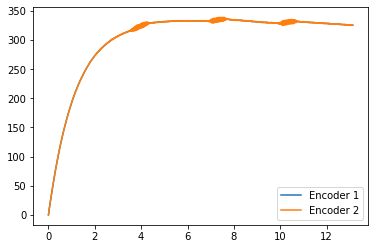

In [13]:
plt.plot(tout, yout[:,(6,7)], label=('Encoder 1', 'Encoder 2'))
plt.legend()
plt.show()

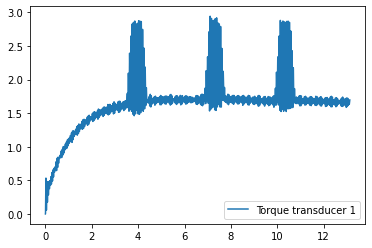

In [14]:
plt.plot(tout, yout[:,30], label='Torque transducer 1')
plt.legend()
plt.show()

In [50]:
def gear_excitation(t,w,A):
    return A*(np.cos(2*w*t)+np.sin(w*t))

In [51]:
B_new = np.zeros((A.shape[0], 3))
B_new[0,0] += 1/inertias[0]
B_new[11,1] += 1/inertias[11]
B_new[len(inertias)-1, 1] -= 1/inertias[-1]

In [52]:
t_sim = np.arange(0, 10, 0.01)
A2, B2 = c2d(Ac, B_new, 0.01)

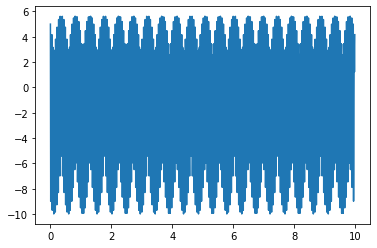

In [53]:
U2 = np.zeros((3, len(t_sim)))
U2[1,:] += gear_excitation(t_sim, 500, 5)
plt.plot(t_sim, U2[1,:])

In [54]:
tout2, yout2, xout2 = dlsim((A2, B2, C, np.zeros((C.shape[0], B2.shape[1])), 0.01), u=U2.T, t=t_sim)

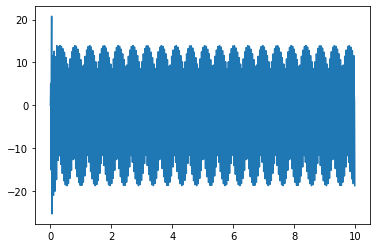

In [55]:
plt.plot(tout2, yout2[:,33])